In [2]:
import pandas as pd
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from string import ascii_uppercase
from numpy import random

In [3]:
db = np.loadtxt('../Frogs_MFCCs.data', delimiter = ',')
#Bufonidae - Rhinella - Rhinellagranulosa
#Dendrobatidae - Ameerega - Ameeregatrivittata
#Hylidae - 1.Dendropsophus, 2.Hypsiboas, 3.Osteocephalus, 4.Scinax - 1.HylaMinuta, 2.HypsiboasCinerascens, 2.HypsiboasCordobae, 3.OsteocephalusOophagus, 4.ScinaxRuber
#Leptodactylidae - 1.Adenomera, 2.Leptodactylus - 1.AdenomeraAndre, 1.AdenomeraHylaedactylus, 2.LeptodactylusFuscus

#Muestras
X = db[:, 0:22]

#Familias
Y = db[:, 22:25]

#Grupos
G = db[:, 25]

In [4]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

## Random Forest (Cross-Validation)

The best model was RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 

Sensibilidad: 0.9298638478409564 - Intervalo Sensibilidad: 0.0802265080009888 
Eficiencia: 0.9794330183435241 - Intervalo Eficiencia: 0.0016206091981226457 
Precision: 0.9652534861135095 - Intervalo Precision: 0.0265856266238917 
F-Score: 0.945480126758801 - Intervalo F-Score: 0.04943501519295228 
Error_Prueba: 0.02056698165647582 - Intervalo Error: 0.0016206091981226518 
Tiempo ejecución: 813.1983001232147


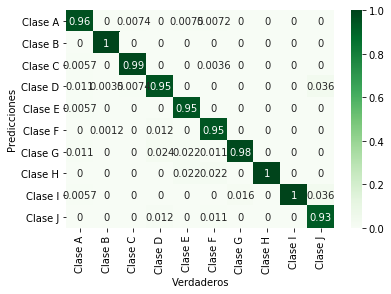

In [6]:
def RF_model_CV(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'n_estimators':(5, 10, 20, 50, 100),
                 'max_features':(2, 5, 10, 13, 15, 19, 22)}
    RF = RandomForestClassifier()
    clf = GridSearchCV(RF, parameters, cv=5)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating confusion matrix 
        _confusion_matrix_ = confusion_matrix(Ytest, Yest)
        TN_array[j] = _confusion_matrix_[0][0]
        FP_array[j] = _confusion_matrix_[0][1]
        FN_array[j] = _confusion_matrix_[1][0]
        TP_array[j] = _confusion_matrix_[1][1]
                
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRF, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RF_model_CV(graficar = True)
print('The best model was', modelRF,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## Random Forest (GroupShuffleSplit)

In [5]:
# Ajjaj
def RF_model_GSS(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'n_estimators':(5, 10, 20, 50, 100),
                 'max_features':(2, 5, 10, 13, 15, 19, 22)}
    RF = RandomForestClassifier()
    group_ShuffleSplit = GroupShuffleSplit(n_splits=10, train_size=.75, random_state=42)
    clf = GridSearchCV(RF, parameters, cv=group_ShuffleSplit.get_n_splits(X, Y[:,2], G))
    scaler = MinMaxScaler()
    scaler.fit_transform(X)
    for j in range(4):
        for train, test in group_ShuffleSplit.split(X, Y[:,2], G):
            Xtrain = X[train,:]
            Ytrain = Y[train,2]
            Xtest = X[test,:]
            Ytest = Y[test,2]
        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating error
        error[j] = classification_error(Yest, Ytest)
        
    if graficar == True:
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')
    
    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRF, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RF_model_GSS(graficar = True)
print('The best model was', modelRF,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

ValueError: Shape of passed values is (10, 10), indices imply (9, 9)

## Random Forest (StratifiedKFold)

In [ ]:
def RF_model_SKF(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'n_estimators':(5, 10, 20, 50, 100),
                 'max_features':(2, 5, 10, 13, 15, 19, 22)}
    RF = RandomForestClassifier()
    SKFold = StratifiedKFold(n_splits=10, random_state=42)
    clf = GridSearchCV(RF, parameters, cv=SKFold.get_n_splits(X, Y[:,2]))
    scaler = MinMaxScaler()
    scaler.fit_transform(X)
    for j in range(4):
        for train, test in SKFold.split(X, Y[:,2]):
            Xtrain = X[train,:]
            Ytrain = Y[train,2]
            Xtest = X[test,:]
            Ytest = Y[test,2]
        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating error
        error[j] = classification_error(Yest, Ytest)
        
    if graficar == True:
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')
    
    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRF, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RF_model_SKF(graficar = True)
print('The best model was', modelRF,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)